In [1]:
import numpy as np
import pandas as pd
import math
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
Excel = pd.read_excel(r'C:\Codes\qPCR scripts\2020-02-06_lib quantify.xlsx')
Excel.head()

,Block Type,96-Well 0.2-mL Block,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32
0,Calibration Background is expired,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Calibration Background performed on,10-11-2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Calibration Pure Dye ABY is expired,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Calibration Pure Dye ABY performed on,10-11-2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Calibration Pure Dye CY5 is expired,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#clean excel
new_header = Excel.loc[46]
data = Excel.iloc[47:, :]
data.columns = new_header
#Get subsets of data
Results = data[["Sample Name", "Task", "CT"]]
#Rename the column names to get rid of "blank"
Results_header = ["Sample", "Task", "CT"]
Results.columns = Results_header
Results

,Sample,Task,CT
47,100pM,STANDARD,7.00972
48,10pM,STANDARD,9.4393
49,1pM,STANDARD,13.6171
50,0.1pM,STANDARD,16.6609
51,R1_j,UNKNOWN,20.6286
52,R1_F1,UNKNOWN,18.9468
53,R1_F2,UNKNOWN,17.559
54,R1_F3,UNKNOWN,19.3082
55,100pM,STANDARD,6.78211
56,10pM,STANDARD,9.0495


In [4]:
#clean up data by NTC, CT bigger than NTC is considered untrustable
Results2 = Results.sort_values("CT")
Results2.reset_index(inplace = True)
Results2

,index,Sample,Task,CT
0,55,100pM,STANDARD,6.78211
1,47,100pM,STANDARD,7.00972
2,56,10pM,STANDARD,9.0495
3,48,10pM,STANDARD,9.4393
4,49,1pM,STANDARD,13.6171
5,57,1pM,STANDARD,14.5111
6,50,0.1pM,STANDARD,16.6609
7,61,R1_F2,UNKNOWN,17.1916
8,53,R1_F2,UNKNOWN,17.559
9,60,R1_F1,UNKNOWN,17.9493


In [5]:
# get the upper and lower limit for valuable samples
index1 = input("starting index number, such as type 0 to get the first line")
index2 = input("ending index number such as type 16 to get the 16th line, indexed as 15")

starting index number, such as type 0 to get the first line0
ending index number such as type 16 to get the 16th line, indexed as 1516


In [6]:
a = int(index1)
b = int(index2)
Result = Results2.iloc[a:b, :]
Result

,index,Sample,Task,CT
0,55,100pM,STANDARD,6.78211
1,47,100pM,STANDARD,7.00972
2,56,10pM,STANDARD,9.0495
3,48,10pM,STANDARD,9.4393
4,49,1pM,STANDARD,13.6171
5,57,1pM,STANDARD,14.5111
6,50,0.1pM,STANDARD,16.6609
7,61,R1_F2,UNKNOWN,17.1916
8,53,R1_F2,UNKNOWN,17.559
9,60,R1_F1,UNKNOWN,17.9493


In [7]:
#Generate standard curve，need to convert datatype into float for math function
Standards = Result.loc[Result["Task"] == 'STANDARD']
Standards["conc"] = Standards.Sample.apply(lambda x:  x[0:-2])
Standards.conc = Standards.conc.astype("float")
Standards["log10_conc"] = Standards.conc.apply(lambda x: np.log10(x))
Standards.CT = Standards.CT.astype("float")
Standards

<ipython-input-7-3dd98332de42>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Standards["conc"] = Standards.Sample.apply(lambda x:  x[0:-2])
C:\Users\16032\AppData\Local\Programs\Python\Python38-32\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-7-3dd98332de42>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

,index,Sample,Task,CT,conc,log10_conc
0,55,100pM,STANDARD,6.782110,100.0,2.0
1,47,100pM,STANDARD,7.009716,100.0,2.0
2,56,10pM,STANDARD,9.049503,10.0,1.0
3,48,10pM,STANDARD,9.439298,10.0,1.0
4,49,1pM,STANDARD,13.617065,1.0,0.0
5,57,1pM,STANDARD,14.511141,1.0,0.0
6,50,0.1pM,STANDARD,16.660885,0.1,-1.0
10,58,0.1pM,STANDARD,18.032125,0.1,-1.0


In [8]:
#use linear regression function from scipy package 
slope, intercept, r_value, p_value, std_err = stats.linregress(Standards.log10_conc, Standards.CT)
print("slope:%f intercept:%f p_value: %f std_err:%f " % (slope, intercept, p_value, std_err))
k = slope
b = intercept
std = std_err

slope:-3.617148 intercept:13.696304 p_value: 0.000006 std_err:0.240992 


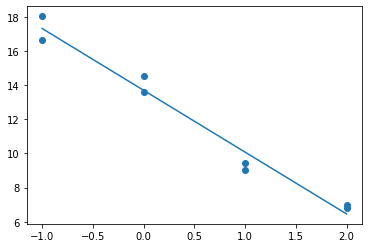

In [9]:
#plot standard curve
plt.scatter(Standards.log10_conc, Standards.CT)
plt.plot(Standards.log10_conc, (k*Standards.log10_conc+b))

In [10]:
#Get the probe concentration of UNKNOWN data
unknown = Result.loc[Result["Task"] == 'UNKNOWN']
unknown['conc'] = unknown.CT.apply(lambda x: pow(10, (x-b)/k) )
unknown

<ipython-input-10-fa907f2abe39>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown['conc'] = unknown.CT.apply(lambda x: pow(10, (x-b)/k) )


,index,Sample,Task,CT,conc
7,61,R1_F2,UNKNOWN,17.1916,0.108067
8,53,R1_F2,UNKNOWN,17.559,0.085532
9,60,R1_F1,UNKNOWN,17.9493,0.066714
11,52,R1_F1,UNKNOWN,18.9468,0.035354
12,62,R1_F3,UNKNOWN,19.2056,0.029983
13,54,R1_F3,UNKNOWN,19.3082,0.028088
14,59,R1_j,UNKNOWN,20.2958,0.014980
15,51,R1_j,UNKNOWN,20.6286,0.012120


In [11]:
Mean = unknown.groupby("Sample").mean()

In [12]:
unknown.to_excel("Output_2020-02-06_lib quantify.xlsx")
Mean.to_excel("Output_Mean_2020-02-06_lib quantify.xlsx")